# Self-Determination Theory (SDT) → Acceptance of Mental-Health Interventions
### Across Three Modalities: Avatar, Chatbot, Teletherapy

The goal of H1 is to test whether self-determination (SDT), measured via TENS_Life_mean, predicts acceptance of:
- AI Avatar interventions
- AI Chatbot interventions
- Teletherapy

General AI-assisted mental-health interventions (UTAUT_AI_mean)

We use harmonized cross-national data from China and the United States.
All continuous predictors are mean-centered.

# 0.0 Library Imports and Paths

In [5]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore", category=FutureWarning)

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data" / "merged"

MERGED_PATH = DATA_DIR / "merged.csv"

# 1.0. Load Processed Data
- We use the fully merged dataset that already contains composite scores and harmonized variables for China + USA.

In [7]:
merged = pd.read_csv(MERGED_PATH)
print("Merged shape:", merged.shape)

Merged shape: (2342, 273)


In [8]:
print("Merged columns:")
print(sorted([c for c in merged.columns if "mean" in c or c in [
    "Accept_avatar", "Accept_chatbot", "Accept_tele",
    "UTAUT_AI_mean", "Country", "gender", "age", "role_label"
]]))

Merged columns:
['AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean', 'AIavatar_PPR_mean', 'AIavatar_SE_mean', 'AIavatar_TQE_mean', 'AIavatar_mean', 'Accept_avatar', 'Accept_chatbot', 'Accept_tele', 'AssistAI_mean', 'Country', 'ET_mean', 'GAAIS_mean', 'HumanTT_CO_mean', 'HumanTT_EOU_mean', 'HumanTT_HC_mean', 'HumanTT_HM_mean', 'HumanTT_PPR_mean', 'HumanTT_SE_mean', 'HumanTT_TQE_mean', 'HumanTT_mean', 'PHQ5_mean', 'SSRPH_mean', 'TENS_Life_mean', 'UTAUT_AI_mean', 'WAI_mean_AIavatar', 'WAI_mean_AIchatbot', 'WAI_mean_TThuman', 'age', 'gender', 'role_label']


# 2.0. Define H1 Variables and Prepare Analytic Sample
H1 focuses on:
- Predictor: TENS_Life_mean (Self-Determination)
- Outcomes: Accept_avatar, Accept_chatbot, Accept_tele, UTAUT_AI_mean
- Covariates: age, gender, PHQ5_mean, SSRPH_mean, GAAIS_mean, ET_mean, Country, role_label

In [9]:
h1_vars = [
    "TENS_Life_mean",
    "Accept_avatar", "Accept_chatbot", "Accept_tele", "UTAUT_AI_mean",
    "age", "gender", "Country", "role_label",
    "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean"
]

## 2.1. Keep only rows that have everything needed for H1

In [10]:
h1_df = merged[h1_vars].copy()
n_total = len(h1_df)
h1_df = h1_df.dropna()
n_complete = len(h1_df)

print(f"H1 analytic sample:")
print(f"Total N in merged: {n_total}")
print(f"N with complete H1 variables: {n_complete}")

H1 analytic sample:
Total N in merged: 2342
N with complete H1 variables: 2085


## 2.2. Basic Checks

In [13]:
print("Country distribution (H1 sample):")
print(h1_df["Country"].value_counts(dropna=False))

Country distribution (H1 sample):
Country
USA      1600
China     485
Name: count, dtype: int64


In [16]:
print("Role distribution (H1 sample):")
print(h1_df["role_label"].value_counts(dropna=False))

Role distribution (H1 sample):
role_label
unknown      1600
therapist     269
client        216
Name: count, dtype: int64


# 3.0. Descriptive Statistics for H1 Variables

In [17]:
continuous_vars = [
    "TENS_Life_mean",
    "Accept_avatar", "Accept_chatbot", "Accept_tele", "UTAUT_AI_mean",
    "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean", "age"
]

print("Descriptive statistics (continuous variables):")
display(h1_df[continuous_vars].describe().T)

Descriptive statistics (continuous variables):


,count,mean,std,min,25%,50%,75%,max
TENS_Life_mean,2085.0,4.768492,1.020626,1.000000,4.000000,4.875000,5.500000,7.000000
Accept_avatar,2085.0,3.706804,0.779151,1.000000,3.272727,3.727273,4.272727,5.000000
Accept_chatbot,2085.0,3.705762,0.808061,1.000000,3.181818,3.727273,4.309524,5.000000
Accept_tele,2085.0,2.713859,0.981622,1.000000,1.909091,2.727273,3.511905,5.000000
UTAUT_AI_mean,2085.0,4.788588,1.384876,1.115385,3.448718,5.000000,6.037037,7.814815
PHQ5_mean,2085.0,1.418705,1.037093,0.000000,0.600000,1.200000,2.200000,4.000000
SSRPH_mean,2085.0,1.245947,0.986910,0.000000,0.400000,1.000000,1.800000,4.000000
GAAIS_mean,2085.0,4.617986,0.795865,2.000000,4.000000,4.625000,5.250000,6.000000
ET_mean,2085.0,4.273573,0.860827,1.000000,3.666667,4.133333,4.800000,7.000000
age,2085.0,33.631655,17.094031,1.000000,23.000000,32.000000,45.000000,85.000000


In [18]:
print("Descriptives for TENS_Life_mean by Country:")
print(h1_df.groupby("Country")["TENS_Life_mean"].describe())

Descriptives for TENS_Life_mean by Country:
          count      mean       std   min       25%       50%  75%  max
Country                                                                
China     485.0  4.351203  0.992311  1.00  3.777778  4.333333  5.0  7.0
USA      1600.0  4.894983  0.995367  1.75  4.250000  5.000000  5.5  7.0


In [19]:
print("Descriptives for acceptance outcomes by Country:")
print(h1_df.groupby("Country")[["Accept_avatar", "Accept_chatbot", "Accept_tele", "UTAUT_AI_mean"]].mean())

Descriptives for acceptance outcomes by Country:
         Accept_avatar  Accept_chatbot  Accept_tele  UTAUT_AI_mean
Country                                                           
China         3.673957        3.692391     3.684413       3.637986
USA           3.716761        3.709815     2.419659       5.137364


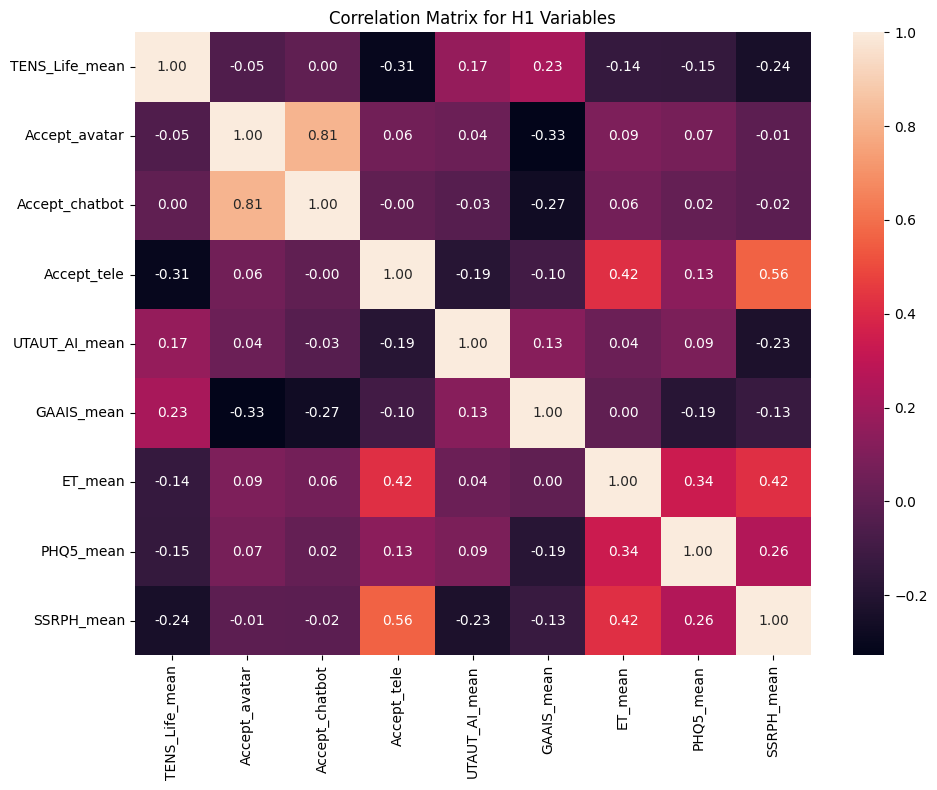

In [20]:
# correlation matrix
plt.figure(figsize=(10, 8))
corr_vars = ["TENS_Life_mean", "Accept_avatar", "Accept_chatbot", "Accept_tele",
             "UTAUT_AI_mean", "GAAIS_mean", "ET_mean", "PHQ5_mean", "SSRPH_mean"]
sns.heatmap(h1_df[corr_vars].corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix for H1 Variables")
plt.tight_layout()
plt.show()

# 4.0. Center Continuous Predictors

In [21]:
center_vars = ["TENS_Life_mean", "GAAIS_mean", "ET_mean", "age"]

for col in center_vars:
    if col in h1_df.columns:
        h1_df[col + "_c"] = h1_df[col] - h1_df[col].mean()

print("Centered variables created:")
print([c for c in h1_df.columns if c.endswith("_c")])

Centered variables created:
['TENS_Life_mean_c', 'GAAIS_mean_c', 'ET_mean_c', 'age_c']


# 5.0. Baseline Models (Without TENS)
- For each intervention type we estimate acceptance as a function of demographics, symptoms, stigma, AI attitudes, trust, country, role.
- This allows us to compute ΔR² when adding TENS (H1).

In [22]:
baseline_outcomes = ["Accept_avatar", "Accept_chatbot", "Accept_tele"]
baseline_results: Dict[str, sm.regression.linear_model.RegressionResultsWrapper] = {}

for outcome in baseline_outcomes:
    cols_needed = [
        outcome, "age", "gender", "PHQ5_mean", "SSRPH_mean",
        "GAAIS_mean", "ET_mean", "Country", "role_label"
    ]
    b_df = h1_df[cols_needed].dropna().copy()

    b_df["age_c"] = b_df["age"] - b_df["age"].mean()

    print(f"\nBaseline model for {outcome} (N={len(b_df)})")

    formula = (
        f"{outcome} ~ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(Country) + C(role_label)"
    )

    model = smf.ols(formula=formula, data=b_df).fit()
    baseline_results[outcome] = model

    display(model.summary().tables[1])
    print(f"R² (baseline {outcome}): {model.rsquared:.3f}")


Baseline model for Accept_avatar (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.6467,0.141,32.854,0.000,4.369,4.924
C(gender)[T.2.0],-0.2148,0.033,-6.575,0.000,-0.279,-0.151
C(gender)[T.3.0],-0.0253,0.111,-0.227,0.820,-0.244,0.193
C(gender)[T.4.0],0.3778,0.273,1.384,0.167,-0.158,0.913
C(Country)[T.USA],0.0992,0.034,2.882,0.004,0.032,0.167
C(role_label)[T.therapist],0.0768,0.066,1.167,0.243,-0.052,0.206
C(role_label)[T.unknown],0.0992,0.034,2.882,0.004,0.032,0.167
age_c,-0.0047,0.001,-3.574,0.000,-0.007,-0.002
PHQ5_mean,-0.0245,0.017,-1.444,0.149,-0.058,0.009
SSRPH_mean,-0.0582,0.022,-2.686,0.007,-0.101,-0.016


R² (baseline Accept_avatar): 0.152

Baseline model for Accept_chatbot (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.6752,0.151,30.955,0.000,4.379,4.971
C(gender)[T.2.0],-0.1644,0.035,-4.713,0.000,-0.233,-0.096
C(gender)[T.3.0],-0.1211,0.119,-1.017,0.309,-0.355,0.112
C(gender)[T.4.0],0.4968,0.292,1.703,0.089,-0.075,1.069
C(Country)[T.USA],0.0519,0.037,1.413,0.158,-0.020,0.124
C(role_label)[T.therapist],0.0325,0.070,0.463,0.643,-0.105,0.170
C(role_label)[T.unknown],0.0519,0.037,1.413,0.158,-0.020,0.124
age_c,-0.0036,0.001,-2.560,0.011,-0.006,-0.001
PHQ5_mean,-0.0504,0.018,-2.782,0.005,-0.086,-0.015
SSRPH_mean,-0.0598,0.023,-2.586,0.010,-0.105,-0.014


R² (baseline Accept_chatbot): 0.101

Baseline model for Accept_tele (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2418,0.144,15.568,0.000,1.959,2.524
C(gender)[T.2.0],0.2220,0.033,6.672,0.000,0.157,0.287
C(gender)[T.3.0],-0.4130,0.114,-3.639,0.000,-0.636,-0.190
C(gender)[T.4.0],0.2158,0.278,0.776,0.438,-0.330,0.761
C(Country)[T.USA],-0.3918,0.035,-11.179,0.000,-0.461,-0.323
C(role_label)[T.therapist],0.0162,0.067,0.242,0.809,-0.115,0.148
C(role_label)[T.unknown],-0.3918,0.035,-11.179,0.000,-0.461,-0.323
age_c,0.0019,0.001,1.422,0.155,-0.001,0.004
PHQ5_mean,-0.0293,0.017,-1.697,0.090,-0.063,0.005
SSRPH_mean,0.2543,0.022,11.526,0.000,0.211,0.298


R² (baseline Accept_tele): 0.446


# 6.0. H1 Models – Main Effect of SDT (TENS_Life_mean_c)
- Add TENS_Life_mean_c to the same baseline models.
- Also include global AI acceptance (UTAUT_AI_mean) outcome.

In [23]:
print("=== H1: SDT → Acceptance per Intervention and Global AI Attitudes ===")

h1_outcomes = ["Accept_avatar", "Accept_chatbot", "Accept_tele", "UTAUT_AI_mean"]
h1_results: Dict[str, sm.regression.linear_model.RegressionResultsWrapper] = {}

for outcome in h1_outcomes:
    cols_needed = [
        outcome, "TENS_Life_mean_c", "age_c", "gender",
        "PHQ5_mean", "SSRPH_mean", "GAAIS_mean", "ET_mean",
        "Country", "role_label"
    ]

    # Some variables (e.g., age_c) were defined in the full h1_df; ensure present
    if "age_c" not in h1_df.columns:
        h1_df["age_c"] = h1_df["age"] - h1_df["age"].mean()

    m_df = h1_df[cols_needed].dropna().copy()

    print(f"\nH1 model for {outcome} (N={len(m_df)})")

    formula = (
        f"{outcome} ~ TENS_Life_mean_c "
        "+ age_c + C(gender) "
        "+ PHQ5_mean + SSRPH_mean + GAAIS_mean + ET_mean "
        "+ C(Country) + C(role_label)"
    )

    model = smf.ols(formula=formula, data=m_df).fit()
    h1_results[outcome] = model

    display(model.summary().tables[1])
    print(f"R² (H1 {outcome}): {model.rsquared:.3f}")

=== H1: SDT → Acceptance per Intervention and Global AI Attitudes ===

H1 model for Accept_avatar (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.6508,0.143,32.590,0.000,4.371,4.931
C(gender)[T.2.0],-0.2139,0.033,-6.496,0.000,-0.279,-0.149
C(gender)[T.3.0],-0.0255,0.112,-0.229,0.819,-0.244,0.193
C(gender)[T.4.0],0.3767,0.273,1.379,0.168,-0.159,0.912
C(Country)[T.USA],0.0985,0.035,2.847,0.004,0.031,0.166
C(role_label)[T.therapist],0.0758,0.066,1.149,0.251,-0.054,0.205
C(role_label)[T.unknown],0.0985,0.035,2.847,0.004,0.031,0.166
TENS_Life_mean_c,0.0036,0.017,0.218,0.827,-0.029,0.036
age_c,-0.0047,0.001,-3.580,0.000,-0.007,-0.002
PHQ5_mean,-0.0243,0.017,-1.428,0.153,-0.058,0.009


R² (H1 Accept_avatar): 0.152

H1 model for Accept_chatbot (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.7226,0.152,31.031,0.000,4.424,5.021
C(gender)[T.2.0],-0.1541,0.035,-4.388,0.000,-0.223,-0.085
C(gender)[T.3.0],-0.1240,0.119,-1.042,0.297,-0.357,0.109
C(gender)[T.4.0],0.4834,0.291,1.659,0.097,-0.088,1.055
C(Country)[T.USA],0.0434,0.037,1.177,0.239,-0.029,0.116
C(role_label)[T.therapist],0.0207,0.070,0.294,0.769,-0.117,0.159
C(role_label)[T.unknown],0.0434,0.037,1.177,0.239,-0.029,0.116
TENS_Life_mean_c,0.0419,0.018,2.367,0.018,0.007,0.077
age_c,-0.0037,0.001,-2.674,0.008,-0.006,-0.001
PHQ5_mean,-0.0479,0.018,-2.641,0.008,-0.083,-0.012


R² (H1 Accept_chatbot): 0.103

H1 model for Accept_tele (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0970,0.143,14.636,0.000,1.816,2.378
C(gender)[T.2.0],0.1905,0.033,5.760,0.000,0.126,0.255
C(gender)[T.3.0],-0.4042,0.112,-3.611,0.000,-0.624,-0.185
C(gender)[T.4.0],0.2568,0.274,0.936,0.349,-0.281,0.795
C(Country)[T.USA],-0.3659,0.035,-10.534,0.000,-0.434,-0.298
C(role_label)[T.therapist],0.0524,0.066,0.790,0.429,-0.078,0.182
C(role_label)[T.unknown],-0.3659,0.035,-10.534,0.000,-0.434,-0.298
TENS_Life_mean_c,-0.1283,0.017,-7.689,0.000,-0.161,-0.096
age_c,0.0024,0.001,1.808,0.071,-0.000,0.005
PHQ5_mean,-0.0370,0.017,-2.169,0.030,-0.070,-0.004


R² (H1 Accept_tele): 0.461

H1 model for UTAUT_AI_mean (N=2085)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9990,0.231,4.325,0.000,0.546,1.452
C(gender)[T.2.0],-0.0931,0.053,-1.746,0.081,-0.198,0.011
C(gender)[T.3.0],0.0809,0.181,0.448,0.654,-0.273,0.435
C(gender)[T.4.0],0.5582,0.442,1.262,0.207,-0.309,1.426
C(Country)[T.USA],1.1012,0.056,19.665,0.000,0.991,1.211
C(role_label)[T.therapist],0.0722,0.107,0.676,0.499,-0.137,0.282
C(role_label)[T.unknown],1.1012,0.056,19.665,0.000,0.991,1.211
TENS_Life_mean_c,0.0933,0.027,3.470,0.001,0.041,0.146
age_c,-0.0208,0.002,-9.829,0.000,-0.025,-0.017
PHQ5_mean,0.0950,0.028,3.454,0.001,0.041,0.149


R² (H1 UTAUT_AI_mean): 0.296


# 7.0. ΔR² and Effect Size Summary for TENS
- β_TENS, SE, p, 95% CI
- R²_baseline (where available)
- R²_H1
- ΔR² = R²_H1 - R²_baseline

In [24]:
summary_rows = []

for outcome in h1_outcomes:
    h1_model = h1_results[outcome]
    params = h1_model.params
    bse = h1_model.bse
    pvalues = h1_model.pvalues
    conf = h1_model.conf_int()
    r2_h1 = h1_model.rsquared

    beta_tens = params.get("TENS_Life_mean_c", np.nan)
    se_tens = bse.get("TENS_Life_mean_c", np.nan)
    p_tens = pvalues.get("TENS_Life_mean_c", np.nan)
    ci_low, ci_high = conf.loc["TENS_Life_mean_c"]

    # Baseline R² only defined for the three intervention outcomes
    if outcome in baseline_results:
        r2_base = baseline_results[outcome].rsquared
        delta_r2 = r2_h1 - r2_base
    else:
        r2_base = np.nan
        delta_r2 = np.nan

    summary_rows.append({
        "Outcome": outcome,
        "N": int(h1_model.nobs),
        "beta_TENS": beta_tens,
        "SE_TENS": se_tens,
        "p_TENS": p_tens,
        "CI_low": ci_low,
        "CI_high": ci_high,
        "R2_baseline": r2_base,
        "R2_H1": r2_h1,
        "Delta_R2": delta_r2
    })

h1_summary = pd.DataFrame(summary_rows)
h1_summary

,Outcome,N,beta_TENS,SE_TENS,p_TENS,CI_low,CI_high,R2_baseline,R2_H1,Delta_R2
0,Accept_avatar,2085,0.003624,0.016618,8.273881e-01,-0.028966,0.036214,0.151653,0.151672,0.000019
1,Accept_chatbot,2085,0.041940,0.017722,1.804684e-02,0.007185,0.076694,0.100601,0.103024,0.002423
2,Accept_tele,2085,-0.128286,0.016684,2.272585e-14,-0.161006,-0.095567,0.445909,0.461274,0.015365
3,UTAUT_AI_mean,2085,0.093338,0.026901,5.315952e-04,0.040583,0.146093,NaN,0.296366,NaN


# 8.0. Visualization – Predicted Acceptance Across SDT Levels
- For each outcome, we plot model-predicted acceptance as a function of TENS_Life_mean (z-transformed) while holding covariates at their mean or reference categories.

In [25]:
def predicted_curve(model, df, predictor_c: str, predictor_raw: str,
                    outcome: str, n_points: int = 50) -> pd.DataFrame:
    """
    Build a small grid of TENS values from -2 SD to +2 SD and
    get predicted values while holding other covariates at typical values.
    """
    # Reconstruct raw scale: x_c = x - mean(x)
    raw_mean = df[predictor_raw].mean()
    raw_std = df[predictor_raw].std()

    x_vals_raw = np.linspace(raw_mean - 2 * raw_std,
                             raw_mean + 2 * raw_std,
                             n_points)
    x_vals_c = x_vals_raw - raw_mean

    # Build base row with covariates at typical values
    base_row = {}
    for col in model.model.exog_names:
        # Skip intercept, we'll let statsmodels handle it
        if col == "Intercept":
            continue
        if predictor_c in col:
            # We'll override TENS with our grid
            continue

        if col.startswith("C("):
            # Categorical dummies — we'll set them to 0
            base_row[col] = 0.0
        else:
            # Try to map back to a column; if not, set 0
            raw_col = col
            if raw_col in df.columns:
                base_row[col] = df[raw_col].mean()
            else:
                base_row[col] = 0.0

    # Build design matrix rows
    design_rows = []
    for x_c, x_raw in zip(x_vals_c, x_vals_raw):
        row = base_row.copy()
        # Add intercept implicitly; statsmodels will handle via add_constant
        # But because we are using formula-based model, we can use model.predict with a DataFrame of raw vars
        # Simpler: construct a DF with original columns instead of exog_names
        design_rows.append({predictor_raw: x_raw})

    # Better: create a prediction DataFrame directly on original variables
    # with country = reference (e.g., China), role_label = reference (e.g., client),
    # gender = reference (e.g., 1.0 if that's your coding).

    # We'll rebuild on original data columns for clarity instead:

    # Detect reference levels from data
    ref_country = df["Country"].mode()[0]
    ref_role = df["role_label"].mode()[0]
    ref_gender = df["gender"].mode()[0]

    pred_df = pd.DataFrame({
        predictor_raw: x_vals_raw,
        "TENS_Life_mean_c": x_vals_c,
        "age_c": 0.0,
        "PHQ5_mean": df["PHQ5_mean"].mean(),
        "SSRPH_mean": df["SSRPH_mean"].mean(),
        "GAAIS_mean": df["GAAIS_mean"].mean(),
        "ET_mean": df["ET_mean"].mean(),
        "gender": ref_gender,
        "Country": ref_country,
        "role_label": ref_role,
    })

    preds = model.predict(pred_df)

    out = pd.DataFrame({
        predictor_raw: x_vals_raw,
        predictor_c: x_vals_c,
        "predicted": preds
    })
    out["Outcome"] = outcome
    return out

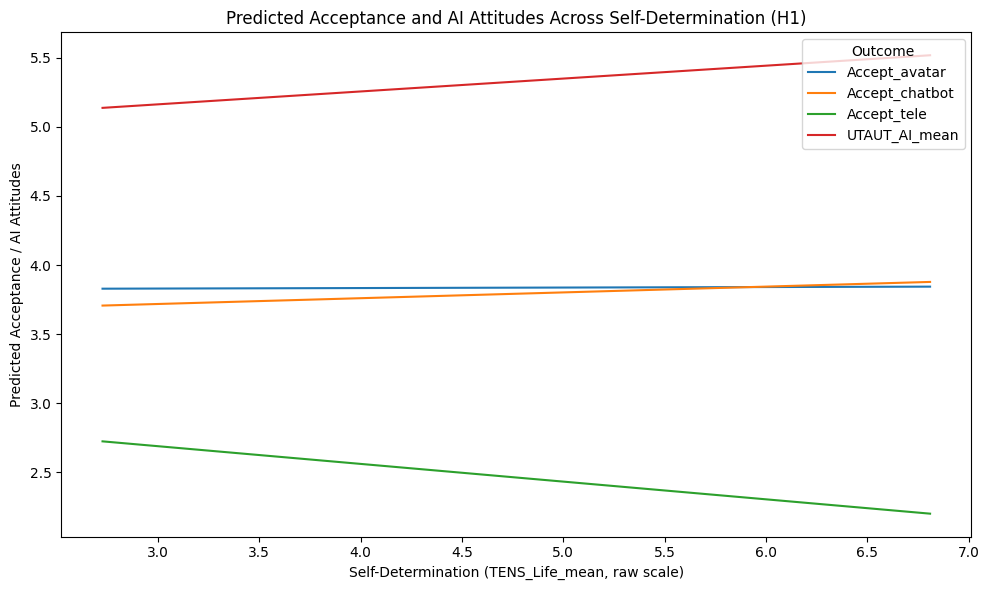

In [26]:
plot_data = []
for outcome in h1_outcomes:
    model = h1_results[outcome]
    plot_df = predicted_curve(
        model=model,
        df=h1_df,
        predictor_c="TENS_Life_mean_c",
        predictor_raw="TENS_Life_mean",
        outcome=outcome,
        n_points=50
    )
    plot_data.append(plot_df)

plot_data = pd.concat(plot_data, ignore_index=True)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=plot_data,
    x="TENS_Life_mean",
    y="predicted",
    hue="Outcome"
)
plt.xlabel("Self-Determination (TENS_Life_mean, raw scale)")
plt.ylabel("Predicted Acceptance / AI Attitudes")
plt.title("Predicted Acceptance and AI Attitudes Across Self-Determination (H1)")
plt.tight_layout()
plt.show()

# 9.0. Narrative Summary

In [27]:
for _, row in h1_summary.iterrows():
    outcome = row["Outcome"]
    beta = row["beta_TENS"]
    p = row["p_TENS"]
    ci_low = row["CI_low"]
    ci_high = row["CI_high"]
    r2 = row["R2_H1"]
    dR2 = row["Delta_R2"]

    direction = "higher" if beta > 0 else "lower"
    sig = "statistically significant" if p < 0.05 else "not statistically significant"

    print(
        f"For {outcome}, higher SDT (TENS) is associated with {direction} scores "
        f"(β = {beta:.3f}, 95% CI [{ci_low:.3f}, {ci_high:.3f}], p = {p:.3g}). "
        f"The full model explains R² = {r2:.3f} of the variance; "
        f"ΔR² due to adding TENS is {dR2:.3f}."
    )

For Accept_avatar, higher SDT (TENS) is associated with higher scores (β = 0.004, 95% CI [-0.029, 0.036], p = 0.827). The full model explains R² = 0.152 of the variance; ΔR² due to adding TENS is 0.000.
For Accept_chatbot, higher SDT (TENS) is associated with higher scores (β = 0.042, 95% CI [0.007, 0.077], p = 0.018). The full model explains R² = 0.103 of the variance; ΔR² due to adding TENS is 0.002.
For Accept_tele, higher SDT (TENS) is associated with lower scores (β = -0.128, 95% CI [-0.161, -0.096], p = 2.27e-14). The full model explains R² = 0.461 of the variance; ΔR² due to adding TENS is 0.015.
For UTAUT_AI_mean, higher SDT (TENS) is associated with higher scores (β = 0.093, 95% CI [0.041, 0.146], p = 0.000532). The full model explains R² = 0.296 of the variance; ΔR² due to adding TENS is nan.
